# Sample Siemens Analysis

In [1]:
import os
import importlib
from pathlib import Path

print(Path().cwd())

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/CLI-Demos


In [2]:
os.chdir(Path().cwd().parent)

In [3]:
print(Path().cwd())

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS


In [4]:
import pyquantus.utc
import pyquantus.parse.siemens

# Select Image & Phantom and Parse

In [5]:
importlib.reload(pyquantus.parse.siemens)
from pyquantus.parse.siemens import siemensRfParser

In [6]:
imagePath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Siemens RF/im.rfd'
phantomPath = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Siemens RF/phantom.rfd'

In [7]:
bmode, imgData, imgInfo, refData, refInfo = siemensRfParser(imagePath, phantomPath)

# ROI Selection (from GUI)

In [8]:
import pickle

pkl_name = '/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Siemens RF/roi.pkl'

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

In [9]:
from pathlib import Path

assert roi_info["Image Name"] == Path(imagePath).name
assert roi_info["Phantom Name"] == Path(phantomPath).name

In [10]:
splineX = roi_info["Spline X"]
splineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [11]:
importlib.reload(pyquantus.utc)
from pyquantus.utc import AnalysisConfig

config = AnalysisConfig()

config.transducerFreqBand = [2000000, 13000000] # [min, max] (Hz)
config.analysisFreqBand = [4500000, 9500000] # [lower, upper] (Hz)
config.samplingFrequency = 40000000 # Hz
config.axWinSize = 0.54 # axial length per window (mm)
config.latWinSize = 0.54 # lateral length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = 10000000 # Hz

# UTC Analysis

In [12]:
importlib.reload(pyquantus.utc)
from pyquantus.utc import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]

In [13]:
importlib.reload(pyquantus.utc)
from pyquantus.utc import UtcAnalysis

utcAnalysis = UtcAnalysis()
utcAnalysis.ultrasoundImage = ultrasoundImage
utcAnalysis.config = config
utcAnalysis.initAnalysisConfig()
utcAnalysis.splineX = splineX
utcAnalysis.splineY = splineY

In [14]:
utcAnalysis.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (dB/cm/MHz)
utcAnalysis.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [15]:
utcAnalysis.generateRoiWindows()
utcAnalysis.computeUtcWindows();

In [17]:
import numpy as np

mbfArr = [window.results.mbf for window in utcAnalysis.roiWindows]
ssArr = [window.results.ss for window in utcAnalysis.roiWindows]
siArr = [window.results.si for window in utcAnalysis.roiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Attenuation Coefficient:", utcAnalysis.attenuationCoef, "dB/cm/MHz")
print("Backscatter Coefficient:", utcAnalysis.backScatterCoef, "1/cm-sr")
print("w Nakagami Parameter:", utcAnalysis.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis.nakagamiParams[1])
print("Effective Scatterer Diameter:", utcAnalysis.effectiveScattererDiameter, "µm") 
print("Effective Scatterer Concentration:", utcAnalysis.effectiveScattererConcentration, "dB/mm^3")

Average Midband Fit: 42.57620116249942 dB
Average Spectral Slope: -4.136618521729846 dB/MHz
Average Spectral Intercept: 71.52394547522739 dB
Attenuation Coefficient: -3.945959517745118 dB/cm/MHz
Backscatter Coefficient: 0.0 1/cm-sr
w Nakagami Parameter: 17903.128449675325
u Nakagami Parameter: 1.1681842376946316
Effective Scatterer Diameter: 0.03326855158605991 µm
Effective Scatterer Concentration: 7858996.663401918 dB/mm^3


# Visualizations

In [18]:
importlib.reload(pyquantus.utc)
from pyquantus.utc import UtcData

utcData = UtcData()
utcData.utcAnalysis = utcAnalysis

In [19]:
utcData.convertImagesToRGB()

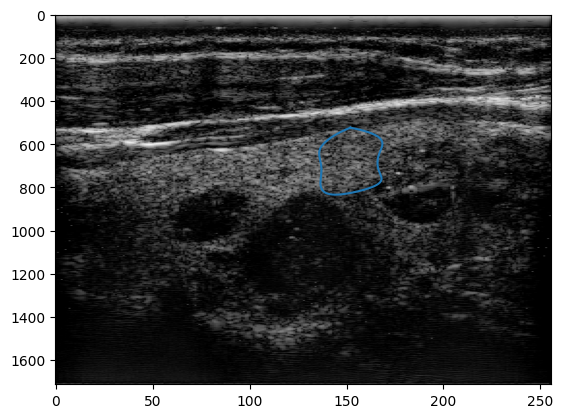

In [20]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.bmode, aspect='auto')
plt.plot(splineX, splineY)

In [21]:
utcData.drawCmaps()

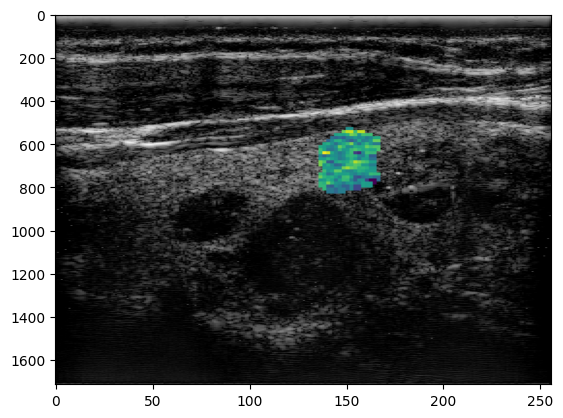

In [22]:
plt.imshow(utcData.mbfIm, aspect='auto')

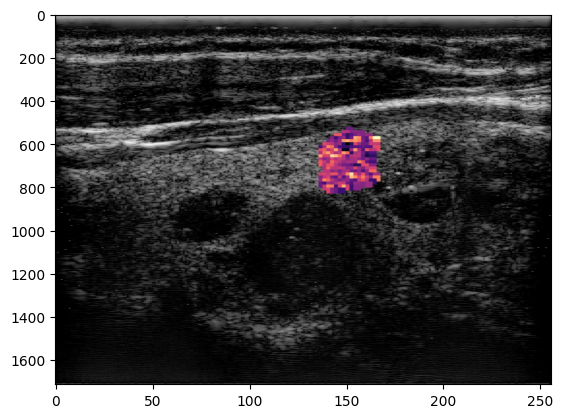

In [23]:
plt.imshow(utcData.ssIm, aspect='auto')

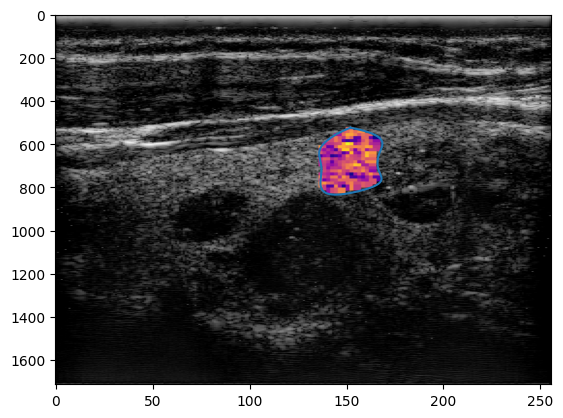

In [24]:
plt.imshow(utcData.siIm, aspect='auto')
plt.plot(utcData.splineX, utcData.splineY)

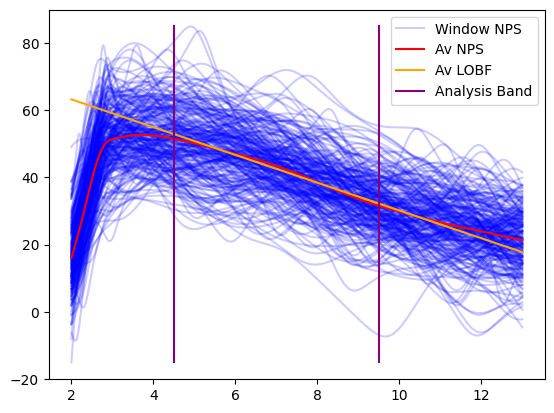

In [25]:
utcData.plotPsData()